In [32]:
%matplotlib inline

## Cats vs Dogs redux

Attempting to configure files etc:

> NOTE: You will need to first set up these dependencies: 
- install the kaggle cli with: `pip install kaggle-cli`
- then set kaggle username and password with `kg config -u <username> -p <password>` (see https://github.com/floydwch/kaggle-cli for details). You will also need to have gone to kaggle and accepted the terms for this challenge before you can download the data.`
- apt-get install unzip

Downloading the data

In [2]:
!kg download -c dogs-vs-cats-redux-kernels-edition

list index out of range


Moving the data into the proper directory

In [4]:
%%bash
mkdir -p data/catsdogs
mv sample_submission.csv data/catsdogs
mv test.zip data/catsdogs
mv train.zip data/catsdogs
cd data/catsdogs
unzip -q ./test.zip
unzip -q ./train.zip

replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [unzip -q ]
replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [./train.z]
replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ip]
replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Formatting the file structure

In [11]:
%%bash
function mv_n_files { # amount, srcDir, targetDir
    for file in $(ls -p $2 | grep -v / | tail -$1)
    do
    mv $2/$file $3
    done
}

function cp_n_files { # amount, srcDir, targetDir
    for file in $(ls -p $2 | grep -v / | tail -$1)
    do
    cp $2/$file $3
    done
}

# # Split train into cat and dog directories
cd data/catsdogs
mkdir -p train/cat
mkdir -p train/dog
cd train
for x in *; do
  case "$x" in
    cat.*) 
       mv -- "$x" cat/
       ;;
  esac
done
for x in *; do 
  case "$x" in 
    dog.*) 
      mv -- "$x" dog/ 
      ;; 
    esac
done
cd -
# mv train/cat.* train/cat
# mv train/dog.* train/dog
mkdir -p test/unknown
cd test
mv *.jpg unknown

# Create validation set
mkdir -p valid/cat
mkdir -p valid/dog
mv_n_files 1000 train/cat valid/cat
mv_n_files 1000 train/dog valid/dog

# Create sample working directory
mkdir -p sample/train/cat
mkdir -p sample/train/dog
mkdir -p sample/valid/cat
mkdir -p sample/valid/dog
mkdir -p sample/test/unknown
sample_size=10
cp_n_files $sample_size train/cat sample/train/cat
cp_n_files $sample_size train/dog sample/train/dog
cp_n_files $sample_size valid/cat sample/valid/cat
cp_n_files $sample_size valid/dog sample/valid/dog
cp_n_files $sample_size test/unknown sample/test/unknown


Set up sample directory

Setting up the data path:

In [18]:
path = "data/catsdogs/sample/"

## Creating the VGG classifier

In [12]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [13]:
# Add to python path dynamically
import sys
sys.path.insert(0, '../../deeplearning1/nbs')

In [14]:
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.


In [15]:
batch_size = 64

In [16]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [49]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/1
20/20 [==============================] - 47s - loss: 1.6136 - acc: 0.4000 - val_loss: 1.1704 - val_acc: 0.5500


In [ ]:
vgg.model.save_weights(path+'results/saved_weights.h5')

## Output predictions to submit
Run predictions on test results

In [43]:
test_batches = vgg.get_batches(path+'test', batch_size=5, class_mode=None)

Found 10 images belonging to 1 classes.


In [45]:
test_imgs = next(test_batches)

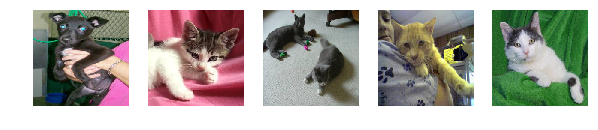

In [48]:
plots(test_imgs[:5])

In [53]:
vgg.predict(test_imgs)

(array([ 0.7539,  0.9399,  0.7258,  0.981 ,  0.8731], dtype=float32),
 array([1, 0, 0, 0, 0]),
 ['dog', 'cat', 'cat', 'cat', 'cat'])

In [56]:
batches, preds = vgg.test(path+'test')

Found 10 images belonging to 1 classes.


In [60]:
filenames = batches.filenames
batches.filenames

['unknown/9999.jpg',
 'unknown/9998.jpg',
 'unknown/9995.jpg',
 'unknown/9994.jpg',
 'unknown/9996.jpg',
 'unknown/9997.jpg',
 'unknown/9993.jpg',
 'unknown/9992.jpg',
 'unknown/9990.jpg',
 'unknown/9991.jpg']

In [67]:
is_dog = preds[:, 1]
is_dog[:5]

array([ 0.019 ,  0.0601,  0.2742,  0.6337,  0.0436], dtype=float32)

In [72]:
file_ids = [int(f[8:f.find('.')]) for f in filenames]
file_ids[:5]

[9999, 9998, 9995, 9994, 9996]

In [73]:
submit_data = np.stack([file_ids, is_dog], axis=1)
submit_data[:5]

array([[  9.9990e+03,   1.9002e-02],
       [  9.9980e+03,   6.0062e-02],
       [  9.9950e+03,   2.7423e-01],
       [  9.9940e+03,   6.3366e-01],
       [  9.9960e+03,   4.3615e-02]])

In [74]:
np.savetxt(path+'submission.csv', submit_data, fmt='%d, %0.5f', header='id,label', comments='')